# **Task 2: Change Point Modeling and Insight Generation**

**1. Importing Key Libraries**

In [36]:
# !pip install ipywidgets

In [37]:
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)

In [38]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath("../Model"))
import warnings
warnings.filterwarnings('ignore')

**2. Load and Prepare Data**

Brent Oil Prices First 5 Record:


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63



Brent Oil Prices Last 5 Record:


,Price
Date,
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25
2022-11-11,96.37
2022-11-14,93.59


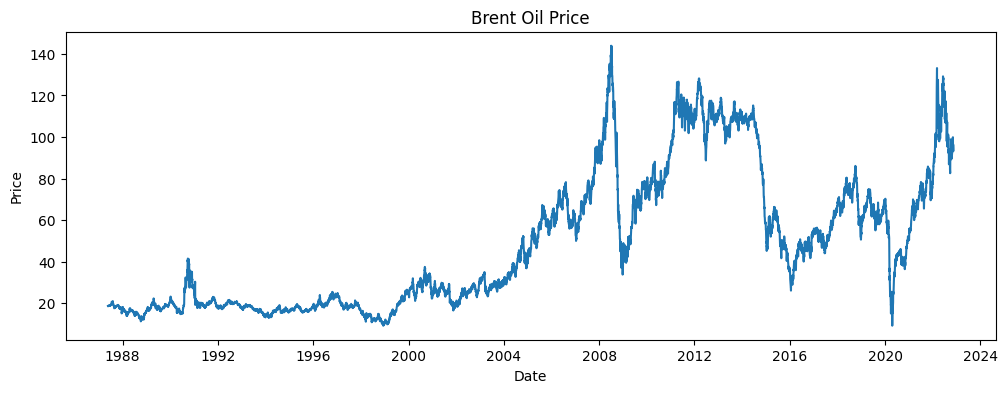

In [39]:
try:
      # Load the Brent Oil Price data
      df = pd.read_csv("BrentOilPrices.csv", parse_dates=["Date"])
      df = df.sort_values("Date")
      df.set_index("Date", inplace=True)
      print("Brent Oil Prices First 5 Record:")
      display(df.head())
      print("\nBrent Oil Prices Last 5 Record:")
      display( df.tail())
      df.shape

      # Plot the log returns
      plt.figure(figsize=(12, 4))
      plt.plot(df.index, df)
      plt.title("Brent Oil Price")
      plt.ylabel("Price")
      plt.xlabel('Date')
      plt.show()
except FileNotFoundError:
      print(f"File {df} not found. Please check the file path.")
except Exception as e:
      print(f"An error occurred: {e}")

**3. Brent Oil Price Return**

In [40]:
# We'll use log returns for change point detection
df['LogReturn'] = np.log(df['Price'] / df['Price'].shift(1))
df.dropna(inplace=True)

log_returns = df['LogReturn']
n = len(log_returns)
try:
      print("\nBrent Oil Log return First 5 Record:")
      display( log_returns.head())
      print("\nBrent Oil Log return Last 5 Record:")
      display( log_returns.tail())
      # display( time_series_price_return.tail())
except FileNotFoundError:
      print(f"File {log_returns} not found. Please check the file path.")
except Exception as e:
      print(f"An error occurred: {e}")


Brent Oil Log return First 5 Record:


,LogReturn
Date,
1987-05-21,-0.009709
1987-05-22,0.005405
1987-05-25,0.002692
1987-05-26,0.001612
1987-05-27,-0.001612



Brent Oil Log return Last 5 Record:


,LogReturn
Date,
2022-11-08,-0.030706
2022-11-09,-0.040026
2022-11-10,0.012814
2022-11-11,0.022244
2022-11-14,-0.029271


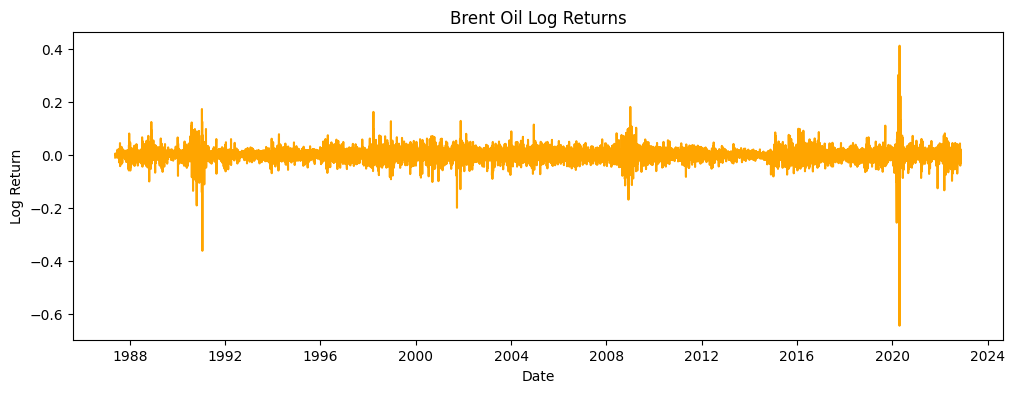

In [8]:
      # Plot the log returns
      plt.figure(figsize=(12, 4))
      plt.plot(df.index, log_returns, color='orange')
      plt.title("Brent Oil Log Returns")
      plt.ylabel("Log Return")
      plt.xlabel('Date')
      plt.show()

**4. PyMC3 Bayesian Change Point Detection Model**

In [41]:
# define probabilistic model
if 'lo_returns' in locals() and not log_returns.empty:
  # convert the log return to numpy array for PyMC
  pymc_log_return  = log_returns.values

with pm.Model() as model:
    # Prior for the change point location (uniform over all time points)
    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=n)

    # Priors for mean before and after the change point
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)

    # Common standard deviation
    sigma = pm.Exponential('sigma', lam=1.0)

    # Define piecewise mean vector
    mu = pm.math.switch(switchpoint >= np.arange(n), mu1, mu2)

    # Likelihood of Observation of log return
    observations = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)

    # Sampling : Inference
    print("\nPyMC Bayesian Volatility  Change detection of Point")
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)
    print("PyMC Sampling Complete")
    print("\nBayesian Volatility Model Sampling is Comepelete,  Summary of Parameters:")
    display(az.summary(trace, var_names=["switchpoint", "mu1","mu2", "sigma"]))


PyMC Bayesian Volatility  Change detection of Point


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


PyMC Sampling Complete

Bayesian Volatility Model Sampling is Comepelete,  Summary of Parameters:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint,5117.314,3118.009,273.000,9010.000,305.772,72.463,92.0,63.0,1.02
mu1,0.000,0.001,-0.001,0.001,0.000,0.000,882.0,502.0,1.00
mu2,0.000,0.017,-0.004,0.004,0.001,0.007,522.0,93.0,1.02
sigma,0.026,0.000,0.025,0.026,0.000,0.000,2091.0,1669.0,1.00


In [49]:
# load and process function
def load_and_preprocess(csv_path):
    try:
        # load the  dataset
        df = pd.read_csv(csv_path, parse_dates=['Date'])
        df.sort_values("Date", inplace=True)
        df["LogReturn"] = np.log(df["Price"]).diff()
        df.dropna(inplace=True)
        return df
    except Exception as e:
        print(f"Error loading or preprocessing data: {e}")
        return None

In [43]:
# building, implementation of change point modeling and infernce
def build_and_sample_model(returns, target_accept=0.95, draws=2000, tune=1000):
    try:
        with pm.Model() as model:
            tau = pm.DiscreteUniform("tau", lower=0, upper=len(returns) - 1)
            mu1 = pm.Normal("mu1", mu=0, sigma=1)
            mu2 = pm.Normal("mu2", mu=0, sigma=1)
            sigma1 = pm.HalfNormal("sigma1", sigma=1)
            sigma2 = pm.HalfNormal("sigma2", sigma=1)

            mu = pm.math.switch(tau >= np.arange(len(returns)), mu1, mu2)
            sigma = pm.math.switch(tau >= np.arange(len(returns)), sigma1, sigma2)

            obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=returns)

            trace = pm.sample(draws=draws, tune=tune, return_inferencedata=True, target_accept=target_accept)
        return model, trace
    except Exception as e:
        print(f"Error building or sampling model: {e}")
        return None, None

In [44]:
def extract_change_point(trace, dates):
    try:
        tau_posterior = trace.posterior["tau"].values.flatten()
        most_probable_tau = int(np.median(tau_posterior))
        change_date = dates[most_probable_tau]
        return most_probable_tau, change_date
    except Exception as e:
        print(f"Error extracting change point: {e}")
        return None, None

In [50]:
def plot_results(df, change_date, trace):
    try:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(df["Date"], df["LogReturn"], label="Log Returns")
        ax.axvline(change_date, color="yellow", linestyle="--", label="Change Point")
        ax.set_title("Detected Change Point in Brent Oil Log Returns")
        ax.legend()
        plt.show()

        az.plot_posterior(trace, var_names=["tau", "mu1", "mu2", "sigma1", "sigma2"])
        plt.show()
    except Exception as e:
        print(f"Error plotting results: {e}")

In [45]:
df = load_and_preprocess('/content/BrentOilPrices.csv')
returns = df["LogReturn"].values
dates = df["Date"].values

 **5. Posterior Analysis**

In [46]:
model, trace = build_and_sample_model(returns)

Output()

In [47]:
model_summary = az.summary(trace, var_names=["tau", "mu1", "mu2", "sigma1", "sigma2"])
display(model_summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5386.966,21.999,5345.000,5421.000,1.189,0.715,363.0,585.0,1.01
mu1,0.000,0.000,-0.000,0.001,0.000,0.000,4583.0,2489.0,1.00
mu2,-0.000,0.000,-0.001,0.001,0.000,0.000,5011.0,2680.0,1.00
sigma1,0.023,0.000,0.023,0.023,0.000,0.000,5307.0,2589.0,1.00
sigma2,0.029,0.000,0.028,0.029,0.000,0.000,4737.0,2545.0,1.00


In [48]:
model

In [32]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [33]:
most_probable_tau, change_date = extract_change_point(trace, dates)
# most_probable_tau
# change_date
print(f"Most Probable Change Point: {most_probable_tau} (Date: {change_date})")

Most Probable Change Point: 5395 (Date: 2008-08-06T00:00:00.000000000)


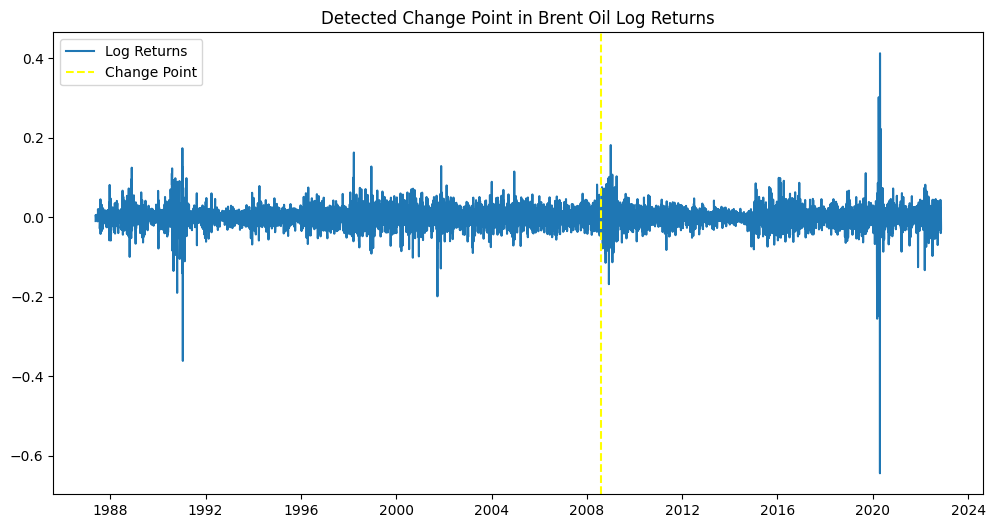

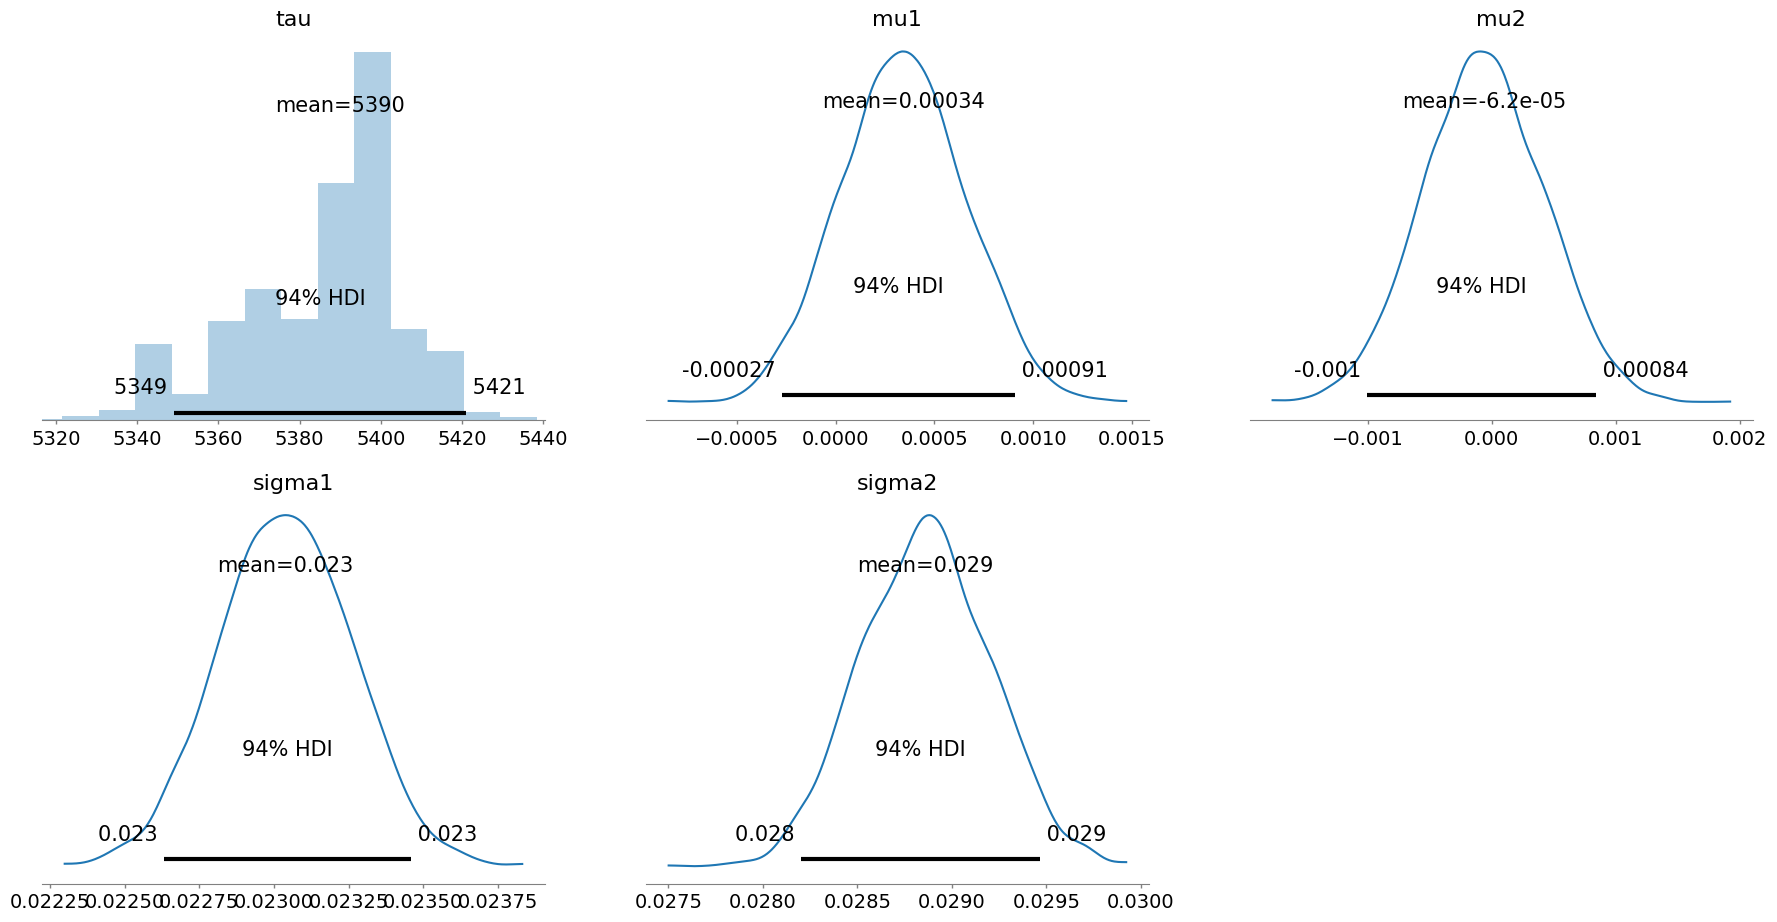

In [34]:
plot_results(df, change_date, trace)

**6. Visualize Change Point on Time Series**

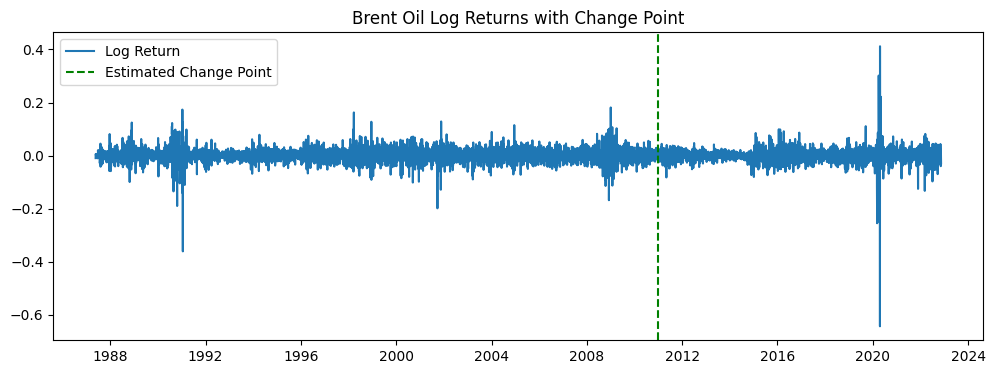

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, log_returns, label='Log Return')
plt.axvline(df.index[change_point], color='green', linestyle='--', label='Estimated Change Point')
plt.title("Brent Oil Log Returns with Change Point")
plt.legend()
plt.show()